# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [28]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 30 
BATCH_SIZE = 64

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K_hat = 8                  # number of VMD modes (tuneable)
alpha_hat = 1705             # VMD alpha (tuneable)
tau_hat = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import random
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate


In [30]:
save_dir = os.path.expanduser("~/Project/Nested_Attention_BiLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


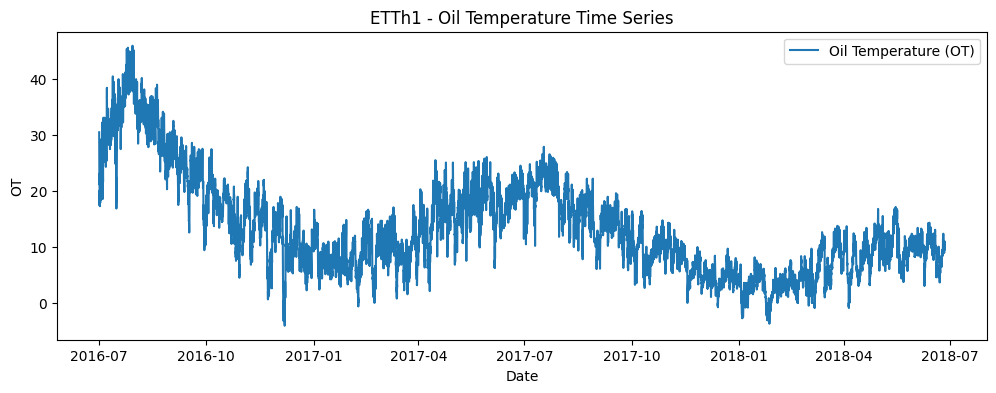

In [31]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [32]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

    
def train_test(alpha=1, tau=1, K=1):
    # --- VMD on train and test ---
    u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
    u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

    vmd_train = np.stack(u_train, axis=1)
    vmd_test  = np.stack(u_test,  axis=1)

    # --- Scale features & target ---
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    train_scaled_vmd = scaler_x.fit_transform(vmd_train)
    train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
    test_scaled_vmd  = scaler_x.transform(vmd_test)
    test_scaled_target  = scaler_y.transform(test_data[[TARGET_COL]])

    # --- Sequence generation (aligned) ---
    X_train_vmd, y_train_vmd = create_sequences(train_scaled_vmd, train_scaled_target, SEQ_LEN)
    X_test_vmd,  y_test_vmd  = create_sequences(test_scaled_vmd,  test_scaled_target,  SEQ_LEN)
    X_train_simple, y_train_simple = create_sequences(train_scaled_target,train_scaled_target,SEQ_LEN)
    X_test_simple, y_test_simple = create_sequences(test_scaled_target,test_scaled_target,SEQ_LEN)
    y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
    y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)

    return y_test_vmd_true,y_test_simple_true,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,X_train_simple,y_train_simple,X_test_simple,y_test_simple



## CUSTOM LAYERS

In [33]:
# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out




def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                             dense_units=32, num_heads=8, model_dim=128):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)

    # -------------------------
    # 1. First LSTM Encoder
    # -------------------------
    enc_out = Bidirectional(LSTM(lstm1_units, return_sequences=True))(encoder_inputs)  # (batch, seq_len, 2*lstm1_units)
    # 🔹 Add Layer Normalization here
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  # convert to model_dim
     # 🔹 Another LayerNorm (optional but recommended)
    enc_out = LayerNormalization()(enc_out)
    # -------------------------
    # 1b. Bahdanau Attention applied to LSTM output
    # -------------------------
    bahdanau_att = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att)

    # -------------------------
    # 2. Second LSTM Decoder
    # -------------------------
    dec_out = Bidirectional(LSTM(lstm2_units, return_sequences=False))(bahdanau_att_exp)
    dec_out = Dense(model_dim)(dec_out)  # convert to model_dim
    dec_out = LayerNormalization()(dec_out)

    # -------------------------
    # 3. TFT Multi-Head Attention
    # -------------------------
    att_layer = TFTTemporalAttention(
        num_heads=num_heads,
        model_dim=model_dim
    )
    att_out = att_layer([enc_out, dec_out])  # encoder_out, decoder_state



    att_layer = TFTTemporalAttention(
        num_heads=num_heads,
        model_dim=model_dim
    )
    att_out = att_layer([att_out, dec_out])
    # -------------------------
    # 
    # add as manay as you want here - just put on following code 
    # 
    #   att_layer = TFTTemporalAttention(
    #      num_heads=num_heads,
    #     model_dim=model_dim)
    #   att_out = att_layer([att_out, dec_out])
    # -------------------------

    
    # -------------------------
    # 5. Dense Output
    # -------------------------
    x = LSTM(dense_units)(att_out)
    output = Dense(1)(x)
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model    

# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 24, 132)        │        74,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_5     │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,633 (939.97 KB)

 Trainable params: 240,633 (939.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0080 - mae: 0.0554 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 9.7092e-04 - val_mae: 0.0275
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 2.5564e-04 - val_mae: 0.0118
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.1773e-04 - mae: 0.0202 - val_loss: 5.6151e-04 - val_mae: 0.0208
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6662e-04 - mae: 0.0178 - val_loss: 1.6050e-04 - val_mae: 0.0096
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8795e-04 - mae: 0.0166 - val_loss: 1.3614e-04 - val_mae: 0.0085
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.4991e-04 - mae: 0.0160 - val_loss: 1.4167e-04 - val_mae: 0.0093
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.5095e-04 - mae: 0.0140 - val_loss: 1.0635e-04 - val_mae: 0.0079


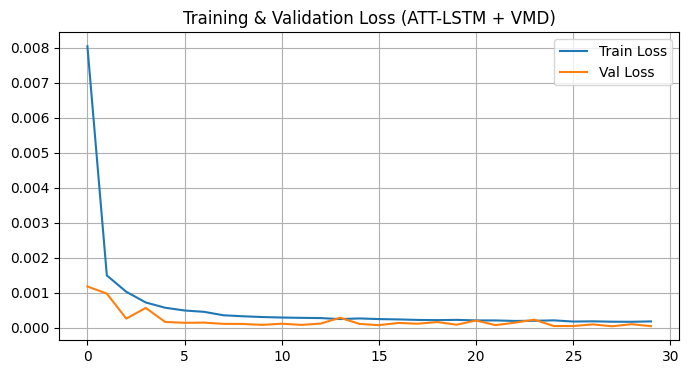

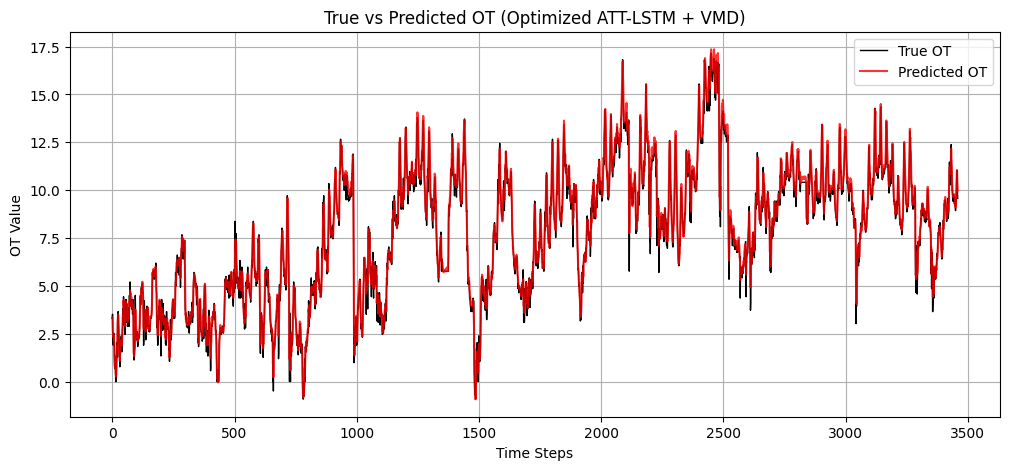

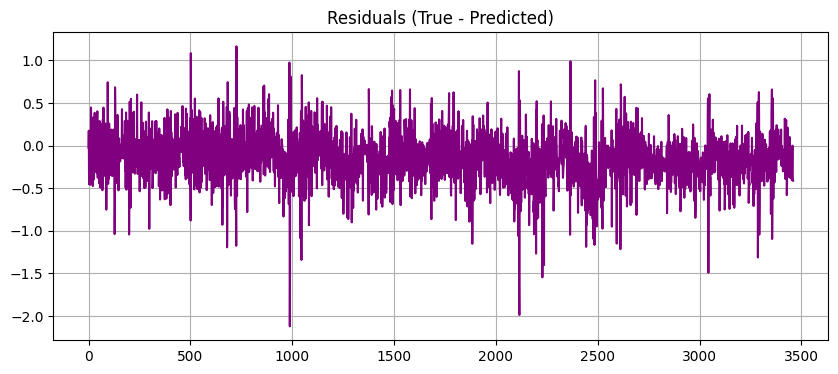

Total Area = 833.6671731807285
Area + = 166.5172654427592
Area - = -667.1499077379692


In [36]:
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
area_total_attlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_vmd)
area_positive_attlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_vmd)
print("Area - =", area_negative_attlstm_vmd)

# TAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 24, 132)        │        74,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention_2            │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,634 (939.98 KB)

 Trainable params: 240,634 (939.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0087 - mae: 0.0568 - val_loss: 0.0010 - val_mae: 0.0254
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0015 - mae: 0.0291 - val_loss: 3.9601e-04 - val_mae: 0.0152
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.3593e-04 - mae: 0.0231 - val_loss: 5.9377e-04 - val_mae: 0.0209
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.9075e-04 - mae: 0.0212 - val_loss: 2.1061e-04 - val_mae: 0.0110
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.6898e-04 - mae: 0.0195 - val_loss: 1.8341e-04 - val_mae: 0.0105
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9299e-04 - mae: 0.0168 - val_loss: 1.5727e-04 - val_mae: 0.0095
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.2290e-04 - mae: 0.0154 - val_loss: 1.0078e-04 - val_mae: 0.0075
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.6631e-04 - mae: 0.0143 - val_loss: 9.0553e-05 - val_mae: 0.007

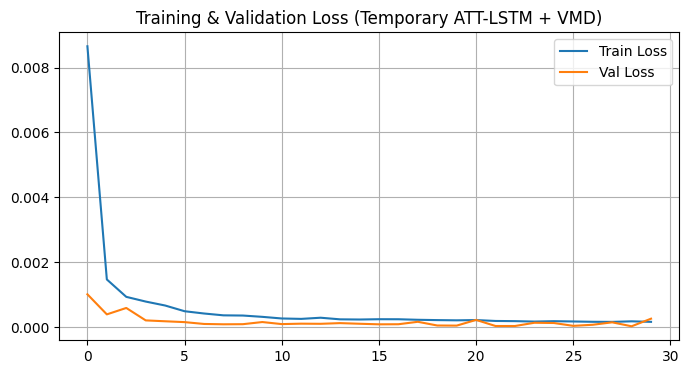

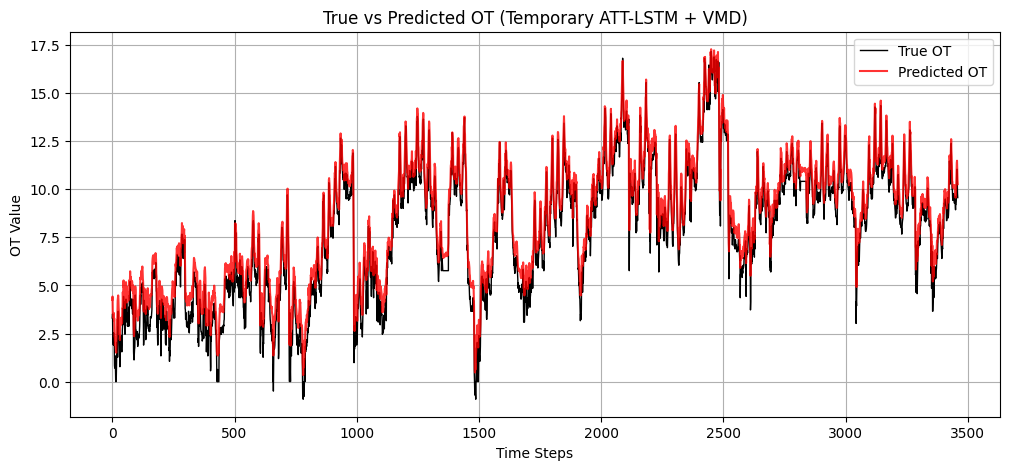

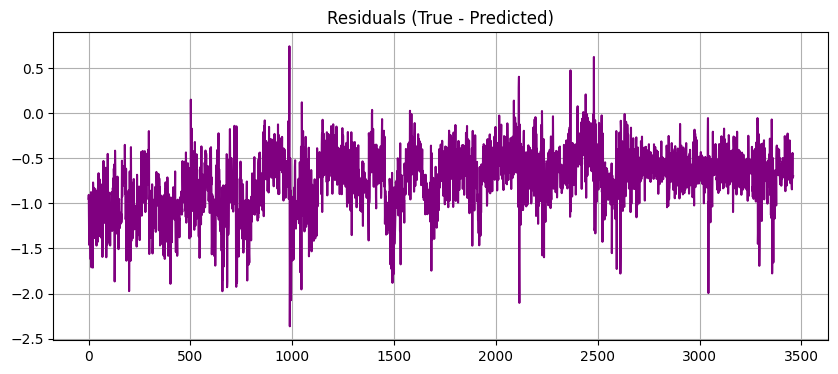

Total Area = 2570.322133630513
Area + = 3.568428993225109
Area - = -2566.7537046372877


In [37]:
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_Tattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
area_total_Tattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm_vmd)
area_positive_Tattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm_vmd)
print("Area - =", area_negative_Tattlstm_vmd)

# TFT Multi-Head Temporal self-Attention lstm

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 24, 80)    │     15,680 │ input_layer_11[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 80)    │        160 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 24, 64)    │      5,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_35[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 80)        │     33,600 │ lambda_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64)        │      5,184 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_36[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ layer_normalizat… │
│ (TFTTemporalAttent… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ tft_temporal_att… │
│ (TFTTemporalAttent… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 16)        │      5,184 │ tft_temporal_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 1)         │         17 │ lstm_25[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,025 (402.44 KB)

 Trainable params: 103,025 (402.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0054 - mae: 0.0337 - val_loss: 2.6289e-04 - val_mae: 0.0133
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.2584e-04 - mae: 0.0140 - val_loss: 8.3427e-05 - val_mae: 0.0068
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.0805e-04 - mae: 0.0111 - val_loss: 1.0724e-04 - val_mae: 0.0082
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.3541e-04 - mae: 0.0120 - val_loss: 2.0685e-04 - val_mae: 0.0129
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.7635e-04 - mae: 0.0104 - val_loss: 6.2177e-05 - val_mae: 0.0062
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.6237e-04 - mae: 0.0098 - val_loss: 6.2996e-05 - val_mae: 0.0060
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.0519e-04 - mae: 0.0112 - val_loss: 6.1694e-05 - val_mae: 0.0059
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.2771e-04 - mae: 0.0088 - val_loss: 1.0011e-04 - val_

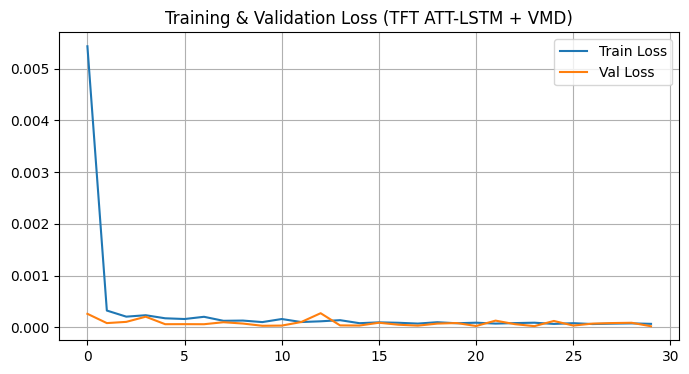

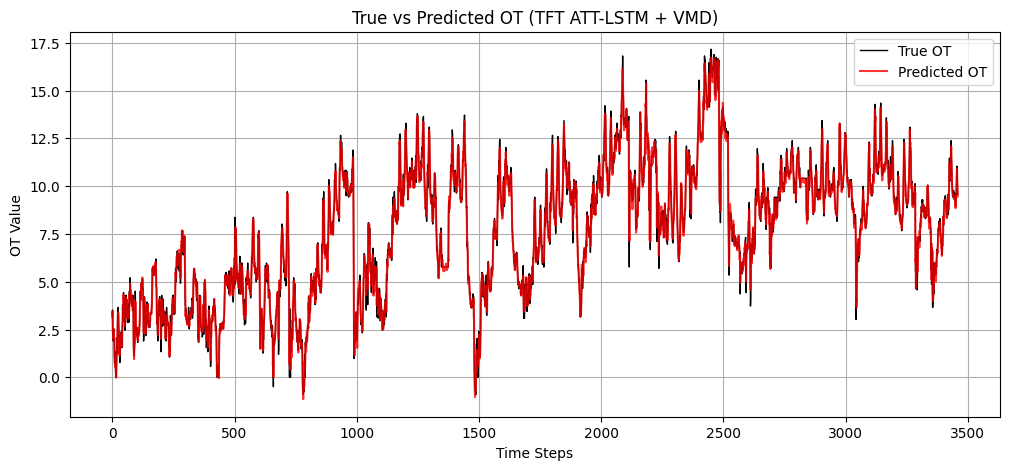

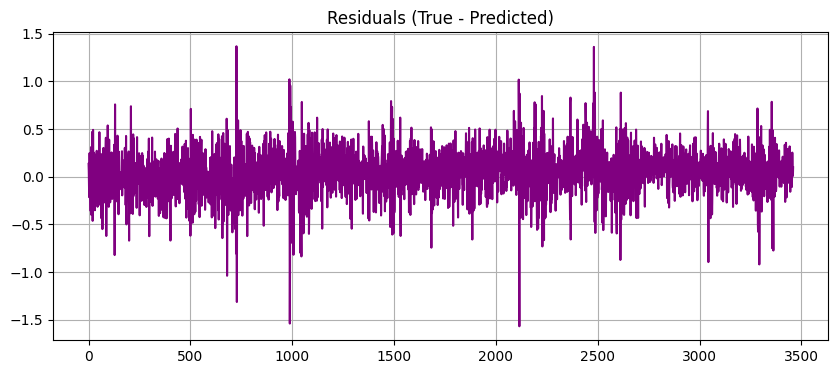

Total Area = 607.795313265699
Area + = 377.0219866260896
Area - = -230.77332663960934


In [38]:
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=40,
    lstm2_units=40,
    dense_units=16,
    num_heads=8,
    model_dim=64
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

# AttnLSTM+SIMPLE

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 24, 122)        │        60,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_7     │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0081 - mae: 0.0560 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0027 - mae: 0.0393 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0025 - mae: 0.0374 - val_loss: 0.0011 - val_mae: 0.0244
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0021 - mae: 0.0347 - val_loss: 8.4293e-04 - val_mae: 0.0225
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 5.1851e-04 - val_mae: 0.0173
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 4.0472e-04 - val_mae: 0.0150
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.9112e-04 - mae: 0.0233 - val_loss: 2.9823e-04 - val_mae: 0.0121
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8.4118e-04 - mae: 0.0212 - val_loss: 2.9325e-04 - val_mae: 0.0121
Epoch 9/30
218/218 ━

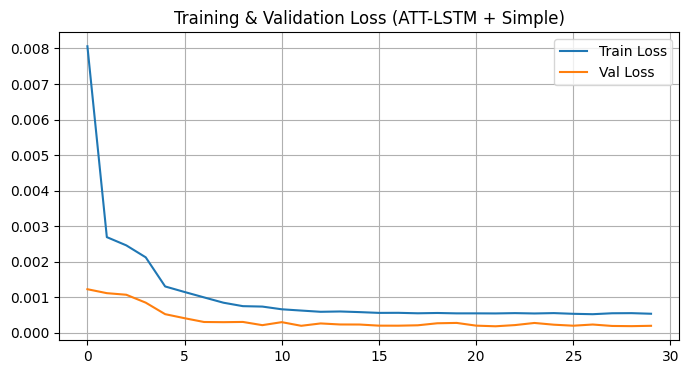

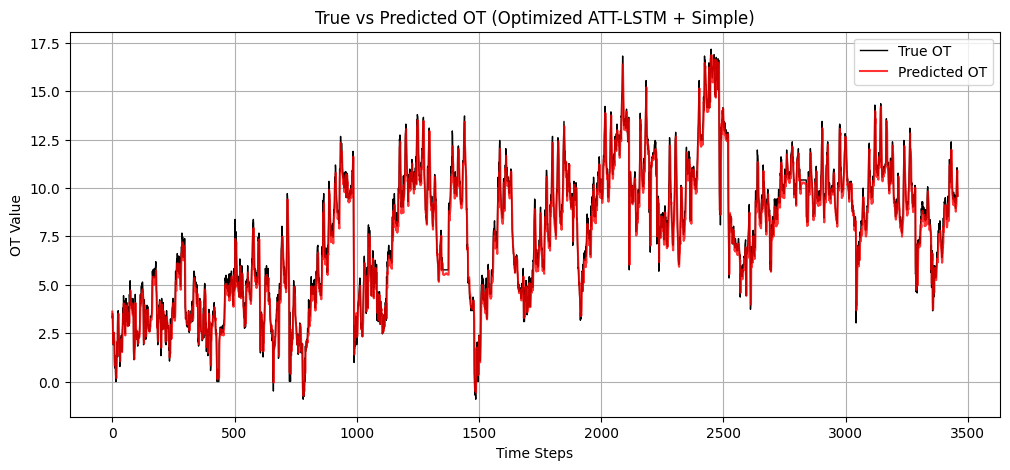

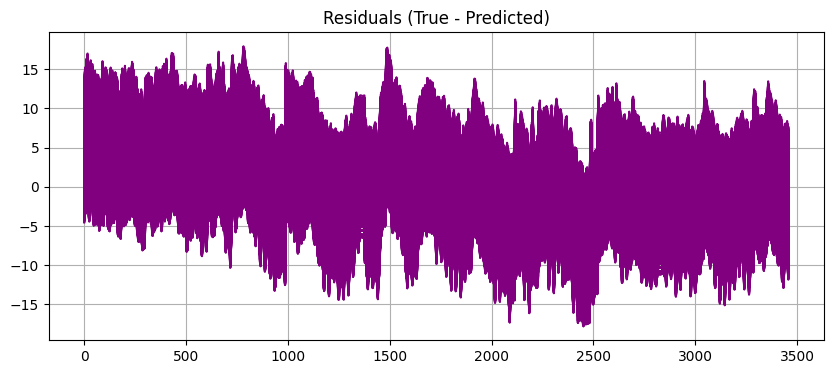

Total Area = 1717.6530730351813
Area + = 1222.0359340161094
Area - = -495.61713901907166


In [39]:
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model_build_attlstm_model.summary()

history_attlstm_simple = model_build_attlstm_model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_model.predict(X_test_simple)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
area_total_attlstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_simple)
area_positive_attlstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_simple)
print("Area - =", area_negative_attlstm_simple)

# BidirectionalLSTM_SIMPLE

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 24, 200)        │        87,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,701 (811.33 KB)

 Trainable params: 207,701 (811.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0054 - mae: 0.0453 - val_loss: 5.5191e-04 - val_mae: 0.0181
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0015 - mae: 0.0289 - val_loss: 3.2872e-04 - val_mae: 0.0131
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 2.8787e-04 - val_mae: 0.0122
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 2.4987e-04 - val_mae: 0.0112
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 4.0698e-04 - val_mae: 0.0160
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.9791e-04 - mae: 0.0235 - val_loss: 2.2251e-04 - val_mae: 0.0105
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.5167e-04 - mae: 0.0228 - val_loss: 2.2359e-04 - val_mae: 0.0106
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8.6254e-04 - mae: 0.0218 - val_loss: 2.6497e-04 - val_mae: 0.0124
Epoc

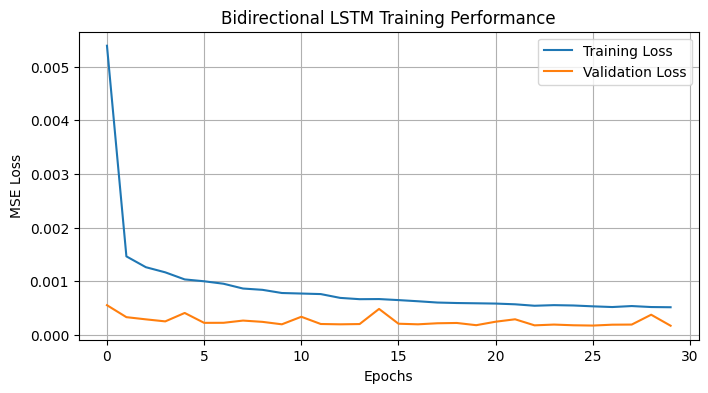

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


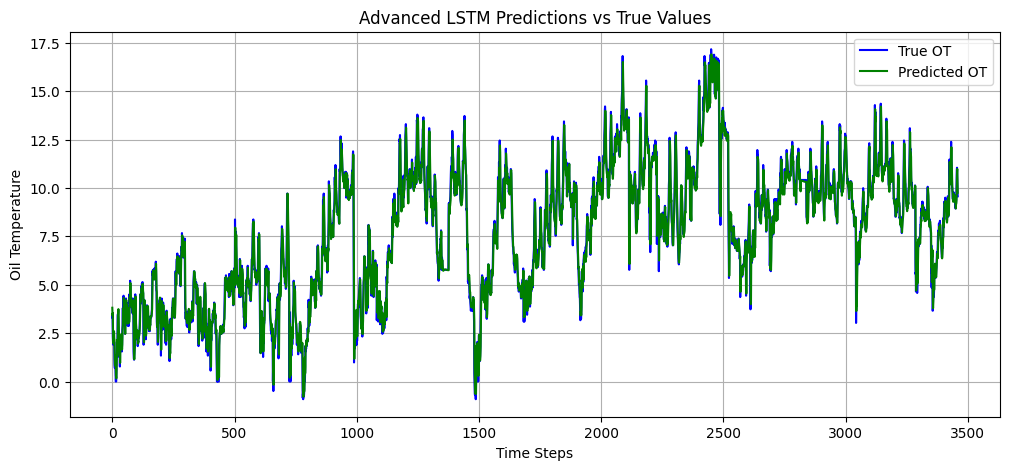

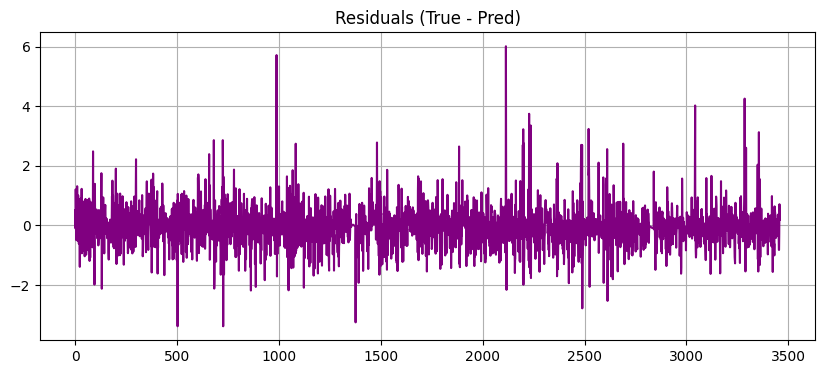

Total Area = 1546.8569087572398
Area + = 856.5726317390809
Area - = -690.284277018159


In [50]:
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

# ---------------------------
# 5. Build Bidirectional_LSTM model
# ---------------------------
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K_hat),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_Bidirectional_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Bidirectional LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_Bidirectional_lstm_simple_true - y_test_simple_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true
area_total_Bidirectional_lstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm_simple)
area_positive_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm_simple)
print("Area - =", area_negative_Bidirectional_lstm_simple)

# LSTM_VMD

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,857 (788.50 KB)

 Trainable params: 201,857 (788.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0052 - mae: 0.0427 - val_loss: 3.2253e-04 - val_mae: 0.0137
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.4268e-04 - mae: 0.0235 - val_loss: 2.1264e-04 - val_mae: 0.0115
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.2775e-04 - mae: 0.0219 - val_loss: 2.4255e-04 - val_mae: 0.0131
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.7533e-04 - mae: 0.0211 - val_loss: 1.9341e-04 - val_mae: 0.0115
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.5656e-04 - mae: 0.0194 - val_loss: 8.1633e-05 - val_mae: 0.0067
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.9601e-04 - mae: 0.0184 - val_loss: 2.3846e-04 - val_mae: 0.0134
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.4538e-04 - mae: 0.0175 - val_loss: 1.2449e-04 - val_mae: 0.0091
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.0722e-04 - mae: 0.0169 - val_loss: 1.1096e-04 - val_

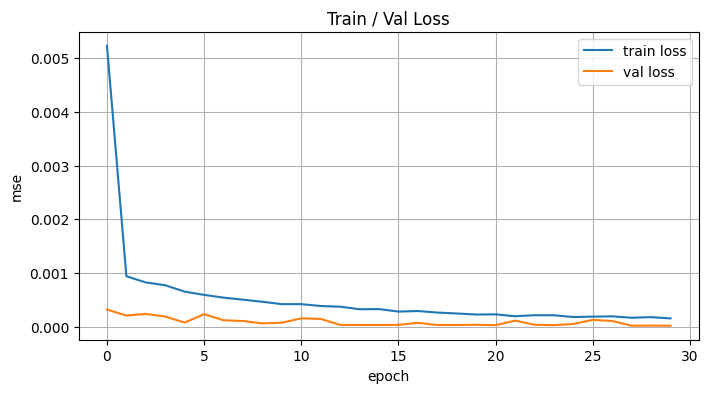

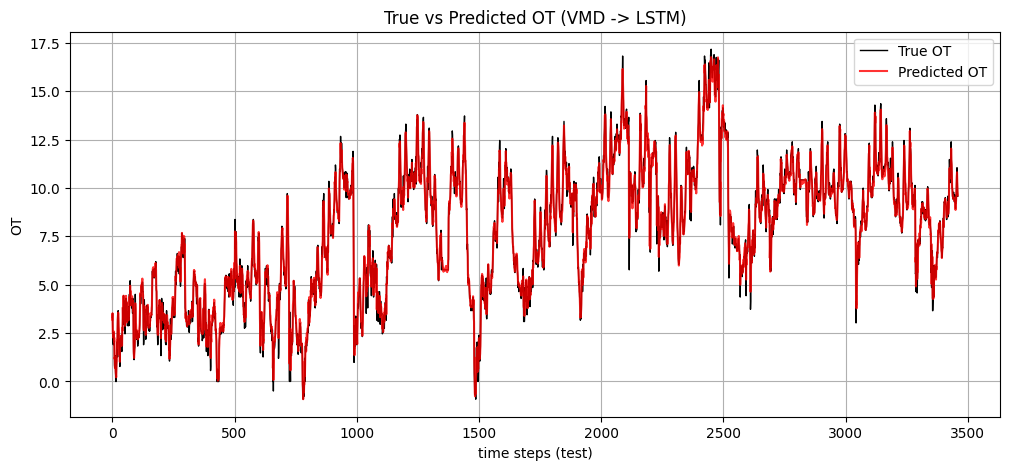

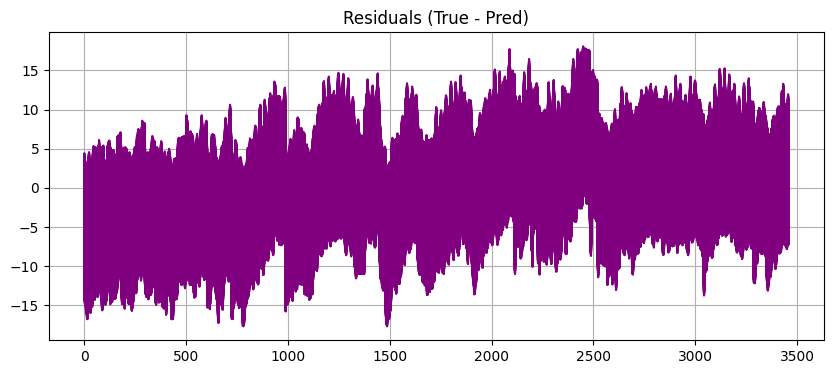

Total Area = 621.1990616768603
Area + = 309.28610762953855
Area - = -311.9129540473217


In [48]:
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, K_hat),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model_lstm_model.predict(X_test_vmd)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_vmd_true - y_pred_lstm_vmd_true 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_lstm_vmd_true
area_total_lstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm_vmd)
area_positive_lstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm_vmd)
print("Area - =", area_negative_lstm_vmd)

# Compare Models

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple, r2_attlstm_simple = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd:.4f}, MAE={mae_Attlstm_vmd:.4f}, R²={r2_attlstm_vmd:.4f}, total_area={area_total_attlstm_vmd:.4f}")
print(f"TATT-LSTM-VMD: MSE={mse_TAttlstm_vmd:.4f}, RMSE={rmse_TAttlstm_vmd:.4f}, MAE={mae_TAttlstm_vmd:.4f}, R²={r2_Tattlstm_vmd:.4f}, total_area={area_total_Tattlstm_vmd:.4f}")
print(f"TFTATT-LSTM-VMD: MSE={mse_TFTAttlstm_vmd:.4f}, RMSE={rmse_TFTAttlstm_vmd:.4f}, MAE={mae_TFTAttlstm_vmd:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm_vmd:.4f}")
print(f"Bidirectional_Lstm_Simple: MSE={mse_Lstm_Bidirectional_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}, total_area={area_total_Bidirectional_lstm_simple:.4f}")
print(f"Attlstm_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple:.4f}, MAE={mae_Attlstm_simple:.4f}, R²={r2_attlstm_simple:.4f}, total_area={area_total_attlstm_simple:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}, total_area={area_total_lstm_vmd:.4f}")


📈 Model Performance Comparison
ATT-LSTM-VMD: MSE=0.1011, RMSE=0.3180, MAE=0.2410, R²=0.9918, total_area=833.6672
TATT-LSTM-VMD: MSE=0.6604, RMSE=0.8127, MAE=0.7431, R²=0.9357, total_area=2570.3221
TFTATT-LSTM-VMD: MSE=0.0552, RMSE=0.2349, MAE=0.1757, R²=0.9952, total_area=607.7953
Bidirectional_Lstm_Simple: MSE=0.4240, RMSE=0.6511, MAE=0.4472, R²=0.9626, total_area=1546.8569
Attlstm_Simple: MSE=0.4792, RMSE=0.6923, MAE=0.4965, R²=0.9582, total_area=1717.6531
Lstm_vmd: MSE=0.0583, RMSE=0.2415, MAE=0.1796, R²=0.9948, total_area=621.1991


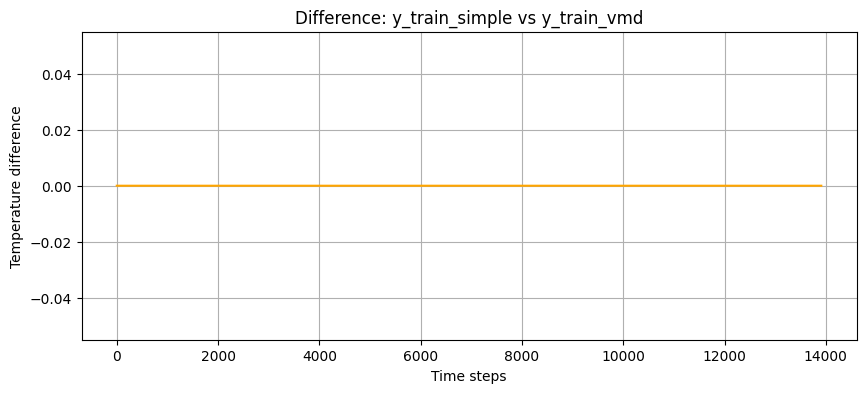

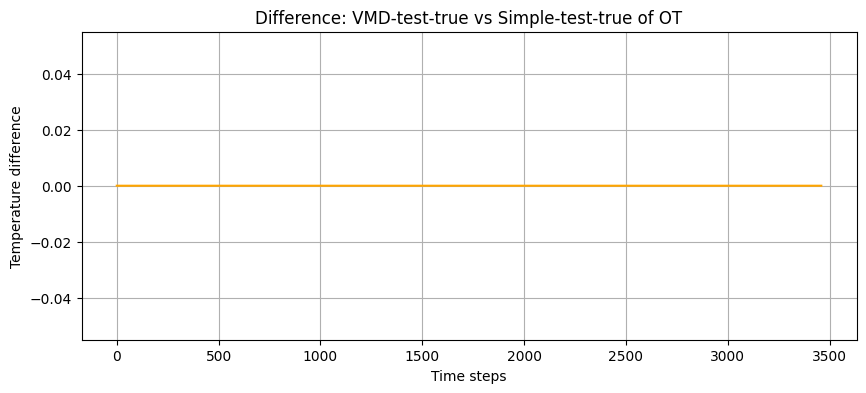

In [26]:
diff = y_train_simple - y_train_vmd
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()